# 第二模型训练（回归/分类）

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import resample

In [53]:
# ======================
# 1. 加载 PTBDB 数据
# ======================

# -------- 健壮读取函数 --------
def load_ptbdb(path, label_if_missing=None):
    # 强制无表头读取
    df = pd.read_csv(path, header=None)
    # 去掉全空列
    df = df.dropna(axis=1, how='all')

    # 检查是否有标签列（只含 0/1 的列）
    y = None
    label_cols = []
    for c in df.columns:
        vals = df[c].dropna().unique()
        if len(vals) <= 2 and set(vals).issubset({0,1}):
            label_cols.append(c)

    if len(label_cols) == 1:
        y = df[label_cols[0]].astype(int).values
        X = df.drop(columns=label_cols).values
    else:
        # 没有标签列 → 用文件类型补标签
        if label_if_missing is None:
            raise ValueError("未找到标签列，请指定 label_if_missing=0/1")
        y = np.full(len(df), int(label_if_missing))
        X = df.values

    return X, y

# -------- 分别读取 normal / abnormal --------
X_normal, y_normal = load_ptbdb("../data/ecg_category/ptbdb_normal.csv", label_if_missing=0)
X_abnormal, y_abnormal = load_ptbdb("../data/ecg_category/ptbdb_abnormal.csv", label_if_missing=1)

# # -------各取500个数据点（测试）--------
# X_normal, y_normal = resample(X_normal, y_normal, n_samples=500, replace=False, random_state=42)
# X_abnormal, y_abnormal = resample(X_abnormal, y_abnormal, n_samples=500, replace=False, random_state=42)

# -------- 对齐特征数（防止列数不一致）--------
min_len = min(X_normal.shape[1], X_abnormal.shape[1])
X_normal = X_normal[:, :min_len]
X_abnormal = X_abnormal[:, :min_len]

# -------- 合并 --------
X_ptbdb = np.vstack([X_normal, X_abnormal])
y_ptbdb = np.concatenate([y_normal, y_abnormal])

# -------- 自检 --------
print("数据维度:", X_ptbdb.shape, y_ptbdb.shape)
print("类别分布:", np.bincount(y_ptbdb))


数据维度: (14552, 188) (14552,)
类别分布: [ 4046 10506]


In [54]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, f1_score, balanced_accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# 假设已准备好 X_ptbdb, y_ptbdb
X = X_ptbdb
y = y_ptbdb.astype(int)

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def pick_best_threshold(y_true_val, y_prob_val, strategy="f1"):
    # 在验证集上选择阈值
    if strategy == "f1":
        thresholds = np.linspace(0.05, 0.95, 19)
        f1s = [f1_score(y_true_val, (y_prob_val >= t).astype(int)) for t in thresholds]
        return thresholds[int(np.argmax(f1s))]
    elif strategy == "youden":
        from sklearn.metrics import roc_curve
        fpr, tpr, thr = roc_curve(y_true_val, y_prob_val)
        J = tpr - fpr
        return thr[int(np.argmax(J))]
    else:
        return 0.5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_reports = []
all_auc = []
all_bal_acc = []

fold = 1
for train_idx, test_idx in skf.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # 再从训练集切出验证集（用于选阈值）
    X_tr_in, X_val, y_tr_in, y_val = train_test_split(
        X_tr, y_tr, test_size=0.15, random_state=42, stratify=y_tr
    )

    # 仅在训练子集上 fit 标准化，防止泄漏
    scaler = StandardScaler().fit(X_tr_in)
    X_tr_in = scaler.transform(X_tr_in)
    X_val   = scaler.transform(X_val)
    X_te    = scaler.transform(X_te)

    # 每折单独计算 class_weight（用训练子集）
    classes = np.unique(y_tr_in)
    cw_vals = compute_class_weight('balanced', classes=classes, y=y_tr_in)
    class_weights = dict(zip(classes, cw_vals))

    # 建模
    model = build_model(X_tr_in.shape[1])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_tr_in, y_tr_in,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=256,
        class_weight=class_weights,
        callbacks=[es], verbose=0
    )

    # 在验证集上选阈值（F1 或 Youden）
    y_val_prob = model.predict(X_val, verbose=0).ravel()
    best_thr = pick_best_threshold(y_val, y_val_prob, strategy="f1")

    # 在测试集上评估
    y_te_prob = model.predict(X_te, verbose=0).ravel()
    y_te_pred = (y_te_prob >= best_thr).astype(int)

    report = classification_report(y_te, y_te_pred, target_names=['Normal(0)','Abnormal(1)'], output_dict=False)
    auc = roc_auc_score(y_te, y_te_prob)
    bal_acc = balanced_accuracy_score(y_te, y_te_pred)

    print(f"\n=== Fold {fold} | thr={best_thr:.2f} ===")
    print(report)
    print(f"ROC-AUC: {auc:.4f} | Balanced Acc: {bal_acc:.4f}")

    all_reports.append(report)
    all_auc.append(auc)
    all_bal_acc.append(bal_acc)
    fold += 1

print(f"\nMean ROC-AUC over folds: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")
print(f"Mean Balanced Acc over folds: {np.mean(all_bal_acc):.4f} ± {np.std(all_bal_acc):.4f}")



=== Fold 1 | thr=0.20 ===
              precision    recall  f1-score   support

   Normal(0)       1.00      1.00      1.00       810
 Abnormal(1)       1.00      1.00      1.00      2101

    accuracy                           1.00      2911
   macro avg       1.00      1.00      1.00      2911
weighted avg       1.00      1.00      1.00      2911

ROC-AUC: 1.0000 | Balanced Acc: 1.0000

=== Fold 2 | thr=0.05 ===
              precision    recall  f1-score   support

   Normal(0)       1.00      1.00      1.00       809
 Abnormal(1)       1.00      1.00      1.00      2102

    accuracy                           1.00      2911
   macro avg       1.00      1.00      1.00      2911
weighted avg       1.00      1.00      1.00      2911

ROC-AUC: 0.9991 | Balanced Acc: 0.9993

=== Fold 3 | thr=0.05 ===
              precision    recall  f1-score   support

   Normal(0)       1.00      1.00      1.00       809
 Abnormal(1)       1.00      1.00      1.00      2101

    accuracy           

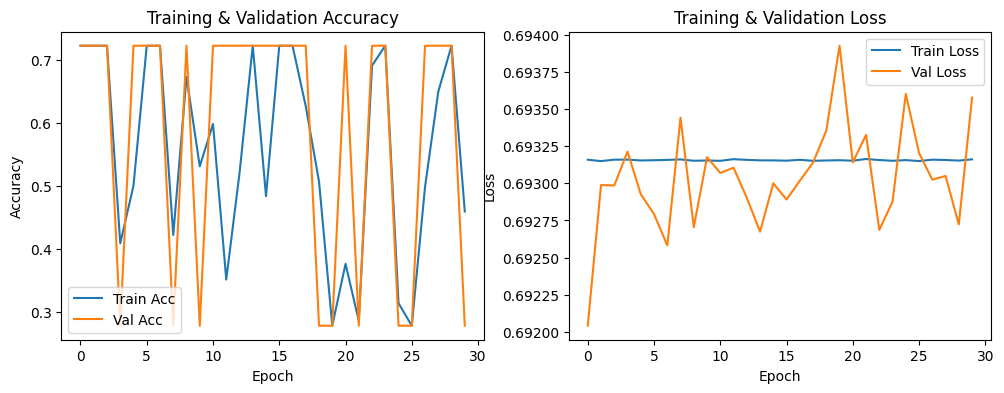

In [57]:
# ======================
# 6. 可视化
# ======================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# 准确率
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# 损失
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()


NaN 总数: 0
NaN 总数: 0


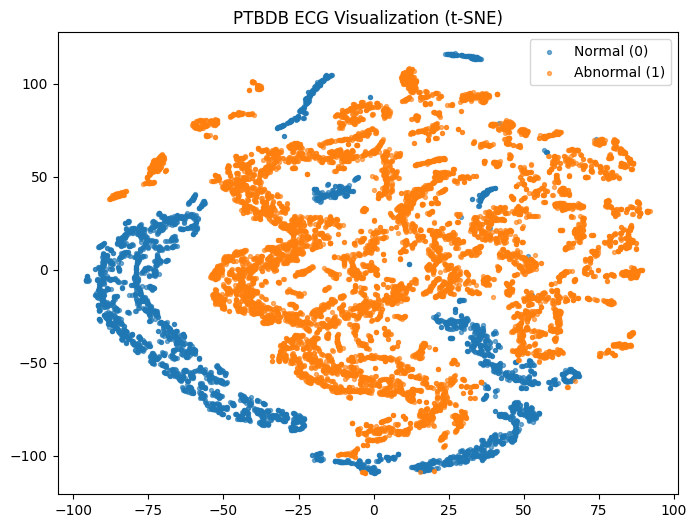

In [55]:
import numpy as np

# 检查是否有 NaN
print("NaN 总数:", np.isnan(X_ptbdb).sum())

# 如果有 NaN，用 0 填充 或者 列均值填充
# 方法1: 全部替换为 0
X_ptbdb = np.nan_to_num(X_ptbdb)

# ====== 数据清理 ======
print("NaN 总数:", np.isnan(X_ptbdb).sum())
X_ptbdb = np.nan_to_num(X_ptbdb)  # 清理 NaN，替换为 0

# ====== PCA 降维到 50 维 ======
X_reduced = PCA(n_components=50, random_state=42).fit_transform(X_ptbdb)

# ====== t-SNE 降维到 2D ======
X_embedded = TSNE(
    n_components=2,
    random_state=42,
    max_iter=1000,   # 用 max_iter 替换 n_iter
    perplexity=30
).fit_transform(X_reduced)

# ====== 绘制散点图 ======
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[y_ptbdb==0,0], X_embedded[y_ptbdb==0,1],
            s=8, alpha=0.6, label="Normal (0)")
plt.scatter(X_embedded[y_ptbdb==1,0], X_embedded[y_ptbdb==1,1],
            s=8, alpha=0.6, label="Abnormal (1)")
plt.legend()
plt.title("PTBDB ECG Visualization (t-SNE)")
plt.show()